In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import scvelo as scv
import scanpy as sc
import pandas as pd
import collections
import numpy as np
import matplotlib
import networkx
import anndata
import network
import fsspec
import igraph
import scvi
import h5py
import desc 
import umap
import h5py
import os

Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [3]:
%load_ext rpy2.ipython
%matplotlib inline 
sc.settings.verbosity = 3     
np.random.seed(42)
sc.set_figure_params(figsize=(2.2, 2.2))

In [ ]:




# Reading in OS384 loom file
adata = scv.read('/Users/brendamelano/Desktop/10xver7/OS384/OS384.loom', cache = True)


# Ensuring that all variable names are unique
adata.var_names_make_unique()


# Annotating mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')


# Computing mitochondrial percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


# Data for the variables
variables = [
    ('n_genes_by_counts', [(4500, '--'), (1000, '--')]),
    ('pct_counts_mt', [(14, '--')]),
    ('total_counts', [(2000, '--'), (19000, '--')])
]


# Dictionary for new titles
titles = {
    'n_genes_by_counts': 'Gene Counts',
    'pct_counts_mt': 'Mito. Percentage',
    'total_counts': 'Total Counts'
}


# Setting the theme without gridlines
sns.set_theme(style="white")


# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5))


# Iterate over the variables and their respective lines to plot
for ax, (var, lines) in zip(axes, variables):
    sns.kdeplot(data=adata.obs, x=var, fill=True, alpha=0.2, ax=ax,
                log_scale=True if var != 'pct_counts_mt' else False)
    for line, style in lines:
        ax.axvline(x=line, color='k', linestyle=style)
    ax.set_title(f"OS384 {titles[var]}")  # Simpler title without extra text
    ax.set_xlabel(titles[var])  # Optionally keep the x-label as the new title
    ax.set_ylabel("Cell density")

    
# Adjust layout to prevent overlap
plt.tight_layout()


# Save the figure as SVG
#plt.savefig("/Users/brendamelano/Desktop/OS384_filtering_plain.svg")


# Show the plot
plt.show()


# Filtering the adata set based on total counts, genes and mitochondrial percentage
adata = adata[(adata.obs['total_counts'] >= 2000) &
                        (adata.obs['total_counts'] <= 19000) &
                        (adata.obs['n_genes_by_counts'] >= 1000) &
                        (adata.obs['n_genes_by_counts'] < 4500) & #pct_counts_mt
                        (adata.obs['pct_counts_mt'] < 14)
                        ]


# weren't the samples filtered in seurat? check which additional cells and genes are filtered out here
scv.pp.filter_genes(adata, min_shared_counts=20)


# Normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)


# filtering the dataset to only keep the most variable genes
# this is redundant to selecting highly variable genes
scv.pp.filter_genes_dispersion(adata, n_top_genes=3000)


# Log scaling
scv.pp.log1p(adata)


# Preserving the counts in counts layer
adata.layers["counts"] = adata.X.copy() 


# freezing the data in raw
adata.raw = adata


# Creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# Selecting highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000, 
    subset=True,
    layer="counts"
)

#genes = adata.var.index.values


cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]


# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]


sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']

# Linear dimensionality reduction
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#adata.raw = adata
adata = adata[:, adata.var.highly_variable]

sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt', 'ccdifference'])


sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')


sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)

sc.tl.umap(adata)

sc.tl.leiden(adata, resolution = 0.55)

# making the var names unique
adata.var_names_make_unique()


genes = adata.var.index.values


# Plotting the UMAP
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon=True,
    title="OS384 Clusters",
    size=20,
    show=False  # Do not display the plot immediately
)

# Save the plot as an SVG file
#plt.savefig("/Users/brendamelano/Desktop/OS384_clusters.svg", format='svg')
plt.show()  

# Reading in the state labeled adata object

In [2]:
# Reading in the adata file from the subtype data
adata = scv.read("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_PCA_subtype.h5ad")


# Plotting based on umap
sc.pl.umap(adata, color=['Subtype'], legend_fontsize=9)

# Marker identification with PCA dim reduction

<Figure size 240x80 with 0 Axes>

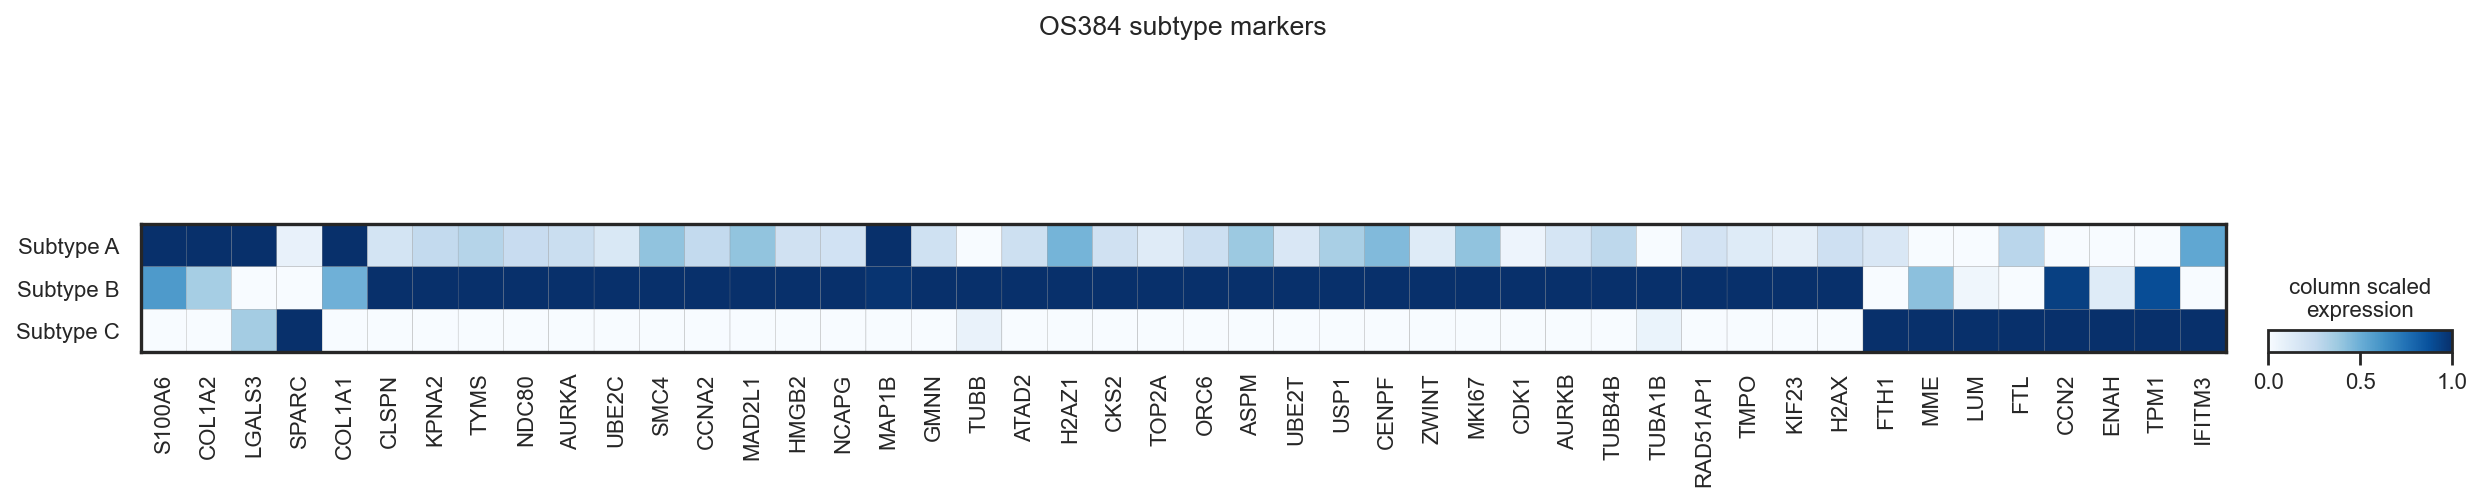

In [5]:
# Read gene lists for each subtype from the CSV files
def read_genes(file_path):
    with open(file_path, 'r') as file:
        genes = [x.strip() for x in file]
    return genes

Subtype_A_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_A_module.csv')
Subtype_B_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv')
Subtype_C_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_C_module.csv')

# Combine gene lists from all subtypes, ensuring uniqueness if necessary
combined_genes = list(set(Subtype_A_genes + Subtype_B_genes + Subtype_C_genes))



# You might want to remove these missing genes from your list before plotting
combined_genes = [gene for gene in combined_genes if gene in adata.var_names]

# Ensure the combined_genes are in your expression data
adata_subset = adata[:, adata.var_names.isin(combined_genes)]

# Create the subtype dictionary 
subtype_A_dict = {gene: 'A' for gene in Subtype_A_genes}
subtype_B_dict = {gene: 'B' for gene in Subtype_B_genes}
subtype_C_dict = {gene: 'C' for gene in Subtype_C_genes}
subtype_dict = {**subtype_A_dict, **subtype_B_dict, **subtype_C_dict}


# Annotate the genes in adata with their subtype
adata.var['subtype'] = [subtype_dict.get(gene, 'Unknown') for gene in adata.var_names]


# Sort the genes in your subset by subtype
adata_subset = adata[:, adata.var_names.isin(combined_genes)]
adata_subset.var['subtype_order'] = adata_subset.var['subtype'].map({'A': 1, 'B': 2, 'C': 3, 'Unknown': 4})
adata_subset = adata_subset[:, adata_subset.var['subtype_order'].argsort()]


# Create a list of genes sorted by subtype for use in the matrixplot
sorted_genes_by_subtype = adata_subset.var_names.tolist()


# Create a figure explicitly
plt.figure(figsize=(3, 1))  # You can adjust the size as needed


# Plotting with Scanpy on the created figure
ax = sc.pl.matrixplot(
    adata_subset,
    var_names=sorted_genes_by_subtype,  # Use the sorted list of genes
    groupby='Subtype',
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    title="OS384 subtype markers",
    show=False  # Do not display the plot immediately
)

# Save matrix plot as svg
plt.savefig("/Users/brendamelano/Desktop/OS384_subtype_markers.svg", format='svg')

plt.show()

plt.close()  # Close the plot to free up memory

# Identifying Subtype A markers

In [ ]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = '1'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS384_subtype_A_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)

OS384_subtype_A_markers

Subtype_A_genes_384 = cluster_markers.iloc[:, 1].tolist()

# Write the array to a CSV file
#np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_subtype_A_markers.csv", Subtype_A_genes_384, delimiter=",", fmt='%s')


# Subtype B marker identification

In [ ]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = '0'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS384_subtype_B_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)

OS384_subtype_B_markers

OS384_subtype_B_markers = OS384_subtype_B_markers.iloc[:, 0].tolist()

OS384_subtype_B_markers

#np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_subtype_B_markers.csv", OS384_subtype_B_markers, delimiter=",", fmt='%s')


# Subtype C Marker identification

In [8]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = '3'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS384_subtype_C_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)


OS384_subtype_C_markers = OS384_subtype_C_markers.iloc[:, 0].tolist()

OS384_subtype_C_markers

#np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_subtype_C_markers.csv", OS384_subtype_C_markers, delimiter=",", fmt='%s')


['AGBL1',
 'LINC02154',
 'DHRS2',
 'ENSG00000254337',
 'NECTIN3-AS1',
 'STMN2',
 'POSTN',
 'CSAG1',
 'IL13RA2',
 'COL8A1',
 'TNFRSF9',
 'LCP1',
 'KRT8',
 'FABP4',
 'TNNT1',
 'MME',
 'GREM1',
 'CDKN1C',
 'IGFBP5',
 'PRICKLE1',
 'HAPLN1',
 'BABAM2',
 'SUGCT',
 'S100A2',
 'LMCD1',
 'LUM',
 'TLE4',
 'SNAI2',
 'SBF2-AS1',
 'SNHG18',
 'CDA',
 'NUAK1',
 'RPS4X',
 'FTH1',
 'PHLDB2',
 'GPNMB',
 'ARID5B',
 'CCN2',
 'COL11A1',
 'DCBLD2',
 'PAWR',
 'PMEPA1',
 'FRMD6',
 'PDLIM1',
 'IFITM3',
 'TCEAL9',
 'TP53I3',
 'BNIP3',
 'IGF1R',
 'ITGA11',
 'FTL',
 'ENAH',
 'ZFP36L1',
 'FHL1',
 'LIMS1',
 'NNMT',
 'UBC',
 'TMSB4X',
 'TPM1',
 'H3-3B']

# Subtype module enrichment

computing score 'State_A_score'
    finished: added
    'State_A_score', score of gene set (adata.obs).
    98 total control genes are used. (0:00:00)
computing score 'Subtype_B_score'
    finished: added
    'Subtype_B_score', score of gene set (adata.obs).
    338 total control genes are used. (0:00:00)
computing score 'Subtype_C_score'
    finished: added
    'Subtype_C_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)


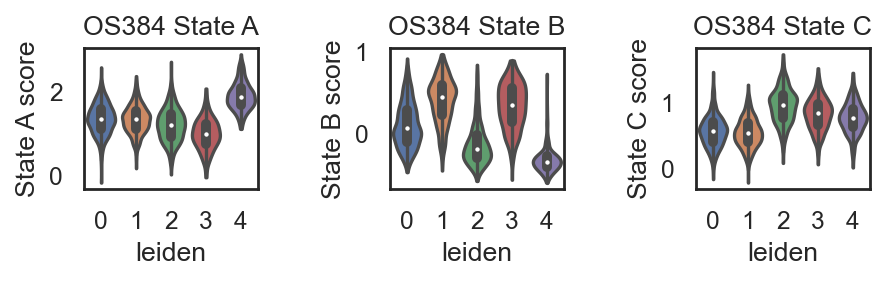

In [2]:
# Reading in gene lists for GSEA
Subtype_A_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_A_module.csv')]
Subtype_B_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv')]
Subtype_C_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_C_module.csv')]


# Keeping only genes that appear in the adata
Subtype_A_genes = [x for x in Subtype_A_genes if x in adata.var_names]
Subtype_B_genes = [x for x in Subtype_B_genes if x in adata.var_names]
Subtype_C_genes = [x for x in Subtype_C_genes if x in adata.var_names]


# Computing GSEA scores
sc.tl.score_genes(adata, Subtype_A_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='State_A_score', random_state=0, copy=False, use_raw=None)
sc.tl.score_genes(adata, Subtype_B_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_B_score', random_state=0, copy=False, use_raw=None)
sc.tl.score_genes(adata, Subtype_C_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_C_score', random_state=0, copy=False, use_raw=None)


# Plotting the results
fig, axs = plt.subplots(1, 3, figsize=(5.7, 1.9))

sc.pl.violin(adata, ['State_A_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel='State A score', ax=axs[0], show=False)
axs[0].set_title('OS384 State A')

sc.pl.violin(adata, ['Subtype_B_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel='State B score', ax=axs[1], show=False)
axs[1].set_title('OS384 State B')

sc.pl.violin(adata, ['Subtype_C_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel='State C score', ax=axs[2], show=False)
axs[2].set_title('OS384 State C')

plt.tight_layout()
plt.savefig('/Users/brendamelano/Desktop/OS384_gsea_scores.svg', format='svg')
plt.show()

# Label subtypes

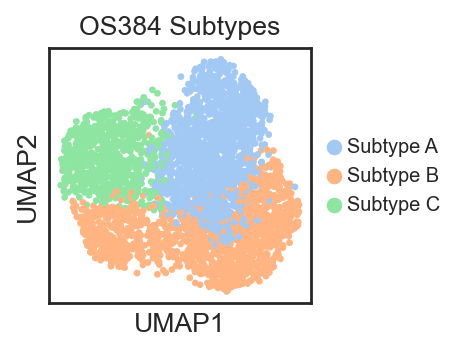

In [4]:
adata.obs['leiden'] = adata.obs['leiden'].astype('category')


adata.obs['leiden'][adata.obs['leiden']=='1']='3'
adata.obs['leiden'][adata.obs['leiden']=='0']='4'



# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'Subtype A': ['4'],  'Subtype B': ['3'], 'Subtype C':['2']}


# Initialize empty column in cell metadata
adata.obs['Subtype'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'Subtype'] = i

    
# creating a dataframe with the cluster IDs
subtypes = pd.DataFrame(adata.obs['Subtype'].values)


# Define the number of clusters
n_subtypes = len(subtypes[0].unique())


# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_subtypes)


# Create a dictionary that maps each cluster ID to a color from the palette
subtype_colors = dict(zip(sorted(subtypes[0].unique()), colors))


# Map the cluster IDs to their corresponding colors
adata.uns['subtype_colors'] = [subtype_colors[c] for c in subtypes[0]]


sc.pl.umap(adata, color=['Subtype'], legend_fontsize=9, title = "OS384 Subtypes", palette = subtype_colors)


# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_PCA_subtype.h5ad")


# Exporting tsv with cell barcode and subtype for MAVE

In [9]:
# Reading in the annotated anndata object
adata = scv.read("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_PCA_subtype.h5ad")


In [10]:
adata.obs.index

Index(['OS384:AACAAGACATCGATGTx', 'OS384:AAACGAATCATAGCACx',
       'OS384:AAAGAACTCTTCCTAAx', 'OS384:AACCAACGTTACACACx',
       'OS384:AACAGGGAGTAAACGTx', 'OS384:AACGAAAAGATCCCATx',
       'OS384:AACAGGGCAAGCCATTx', 'OS384:AACCTGAAGGCCTTCGx',
       'OS384:AAACGAACAGTAACCTx', 'OS384:AAAGGATTCACTTGGAx',
       ...
       'OS384:TTGTGGAGTCTACAGTx', 'OS384:TTGGGTAAGTTTCGACx',
       'OS384:TTTAGTCAGCCGAATGx', 'OS384:TTGTTGTAGCTGCGAAx',
       'OS384:TTTCCTCGTCAGTCCGx', 'OS384:TTTACCAAGGACTATAx',
       'OS384:TTTCGATTCATAGACCx', 'OS384:TTTGATCGTCAACATCx',
       'OS384:TTTGGAGAGCTACAAAx', 'OS384:TTTGGAGAGCGGCTCTx'],
      dtype='object', name='CellID', length=3244)

In [11]:
def generate_tsv_from_anndata(adata, tsv_output_path, meta_col="Subtype"):
    # Use adata.obs.index for barcodes
    barcodes = adata.obs.index
    # Clean the barcodes to remove prefix and suffix and add '-1' suffix
    barcodes = barcodes.str.replace(r'^OS384:', '', regex=True).str.replace(r'x$', '', regex=True) + '-1'
    cell_types = adata.obs[meta_col]
    df = pd.DataFrame({'Barcode': barcodes, meta_col: cell_types})
    df.to_csv(tsv_output_path, sep='\t', index=False)
    print(f"TSV file saved to {tsv_output_path}")

In [12]:
tsv_output_path = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_10Xbarcode_subtype.tsv"
generate_tsv_from_anndata(adata, tsv_output_path)


TSV file saved to /Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_10Xbarcode_subtype.tsv


In [13]:
tsv_output_path = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_10Xbarcode_subtype.tsv"

# Read the TSV file into a DataFrame
df = pd.read_csv(tsv_output_path, sep='\t')
df

,Barcode,Subtype
0,AACAAGACATCGATGT-1,Subtype A
1,AAACGAATCATAGCAC-1,Subtype B
2,AAAGAACTCTTCCTAA-1,Subtype B
3,AACCAACGTTACACAC-1,Subtype A
4,AACAGGGAGTAAACGT-1,Subtype A
...,...,...
3239,TTTACCAAGGACTATA-1,Subtype A
3240,TTTCGATTCATAGACC-1,Subtype A
3241,TTTGATCGTCAACATC-1,Subtype A
3242,TTTGGAGAGCTACAAA-1,Subtype A


In [14]:
from argparse import ArgumentParser
import numpy as np
import os
import pandas as pd
import pysam

In [15]:
def split_bam(bamobj, dict_cells):
    dict_barcodes = {}
    for celltype in dict_cells.keys():
        print(f"Extracting {celltype} barcodes")
        barcodes = dict_cells[celltype]["barcodes"]
        for barcode in barcodes:
            dict_barcodes[barcode] = celltype
    barcodes = np.array(list(dict_barcodes.keys()))
    numreads = 0
    numaddedreads = 0
    for read in bamobj:
        cellbarcode = "0"
        for k in range(len(read.tags)):
            if read.tags[k][0] == "CB":
                cellbarcode = read.tags[k][1]
        if cellbarcode != "0":
            barcode_exists = cellbarcode in barcodes
            good_qual = read.mapq > 10
            if barcode_exists and good_qual:
                celltype = dict_barcodes[cellbarcode]
                dict_cells[celltype]["bamobj"].write(read)
                numaddedreads += 1
        if numreads % 500000 == 0:
            print(f"{numreads} reads analyzed, {numaddedreads} added")
        numreads += 1

def main(bampath, outdir, barcodepath, meta_col, samplename):
    bamobj = pysam.AlignmentFile(bampath, "rb")
    metadf = pd.read_csv(barcodepath, sep="\t")
    metadf = metadf[metadf[meta_col] == samplename]
    adname = samplename.replace(" ", "_")
    outpath = os.path.join(outdir, f"{adname}.bam")
    adobj = pysam.AlignmentFile(outpath, "wb", template=bamobj)
    dict_cells = {
        samplename: {
            "barcodes": np.array(metadf["Barcode"]),
            "bampath": outpath,
            "bamobj": adobj}}
    split_bam(bamobj, dict_cells)
    for celltype in pd.unique(metadf[meta_col]):
        dict_cells[celltype]["bamobj"].close()
    bamobj.close()

In [16]:
BAMPATH = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_possorted_genome_bam.bam"
OUTDIR = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/"#"~/plain_osteo_scRNAseq/os_pdx/OS152/outs"
BARCODEPATH = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_10Xbarcode_subtype.tsv"#"~/plain_osteo_scRNAseq/os_pdx/OS152/outs/OS152_10Xbarcode_subtype.tsv"
Subtypes = ["Subtype A", "Subtype B", "Subtype C"]


In [17]:

for CELLTYPE in Subtypes:
    main(BAMPATH, OUTDIR, BARCODEPATH, "Subtype", CELLTYPE)

Extracting Subtype A barcodes
0 reads analyzed, 0 added
500000 reads analyzed, 148985 added
1000000 reads analyzed, 305453 added
1500000 reads analyzed, 460217 added
2000000 reads analyzed, 617599 added
2500000 reads analyzed, 777027 added
3000000 reads analyzed, 927381 added
3500000 reads analyzed, 1083519 added
4000000 reads analyzed, 1210747 added
4500000 reads analyzed, 1353402 added
5000000 reads analyzed, 1499937 added
5500000 reads analyzed, 1650777 added
6000000 reads analyzed, 1797603 added
6500000 reads analyzed, 1950100 added
7000000 reads analyzed, 2117164 added
7500000 reads analyzed, 2278812 added
8000000 reads analyzed, 2430565 added
8500000 reads analyzed, 2579370 added
9000000 reads analyzed, 2720938 added
9500000 reads analyzed, 2869443 added
10000000 reads analyzed, 3015776 added
10500000 reads analyzed, 3158342 added
11000000 reads analyzed, 3302084 added
11500000 reads analyzed, 3446090 added
12000000 reads analyzed, 3600855 added
12500000 reads analyzed, 3757412 a

20500000 reads analyzed, 7264153 added
21000000 reads analyzed, 7438305 added
21500000 reads analyzed, 7615448 added
22000000 reads analyzed, 7793111 added
22500000 reads analyzed, 7970616 added
23000000 reads analyzed, 8144814 added
23500000 reads analyzed, 8325500 added
24000000 reads analyzed, 8498294 added
24500000 reads analyzed, 8671756 added
25000000 reads analyzed, 8851248 added
25500000 reads analyzed, 9036216 added
26000000 reads analyzed, 9198487 added
26500000 reads analyzed, 9375562 added
27000000 reads analyzed, 9559176 added
27500000 reads analyzed, 9740263 added
28000000 reads analyzed, 9921940 added
28500000 reads analyzed, 10103819 added
29000000 reads analyzed, 10238897 added
29500000 reads analyzed, 10407463 added
30000000 reads analyzed, 10583268 added
30500000 reads analyzed, 10765150 added
31000000 reads analyzed, 10938791 added
31500000 reads analyzed, 11117966 added
32000000 reads analyzed, 11294260 added
32500000 reads analyzed, 11470803 added
33000000 reads a

41000000 reads analyzed, 6238230 added
41500000 reads analyzed, 6312932 added
42000000 reads analyzed, 6391100 added
42500000 reads analyzed, 6468716 added
43000000 reads analyzed, 6540543 added
43500000 reads analyzed, 6612989 added
44000000 reads analyzed, 6687816 added
44500000 reads analyzed, 6761422 added
45000000 reads analyzed, 6828197 added
45500000 reads analyzed, 6902902 added
46000000 reads analyzed, 6970521 added
46500000 reads analyzed, 7047969 added
47000000 reads analyzed, 7128421 added
47500000 reads analyzed, 7209667 added
48000000 reads analyzed, 7262013 added
48500000 reads analyzed, 7343031 added
49000000 reads analyzed, 7413526 added
49500000 reads analyzed, 7486264 added
50000000 reads analyzed, 7561793 added
50500000 reads analyzed, 7636685 added
51000000 reads analyzed, 7715368 added
51500000 reads analyzed, 7799330 added
52000000 reads analyzed, 7876938 added
52500000 reads analyzed, 7958671 added
53000000 reads analyzed, 8046715 added
53500000 reads analyzed, 

# scVI

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██| 400/400 [07:21<00:00,  1.01s/it, loss=1.37e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██| 400/400 [07:21<00:00,  1.10s/it, loss=1.37e+03, v_num=1]
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)


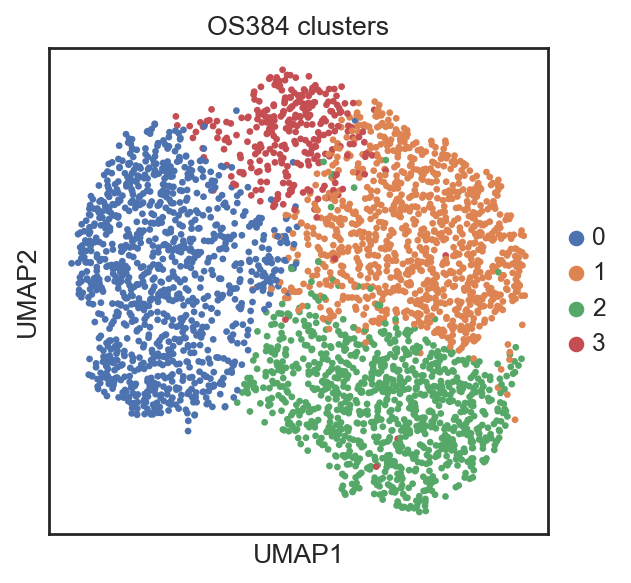

In [2]:
adata = adata.copy()

# Setting up the anndata object to include categorical and continuous covariate variables
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    continuous_covariate_keys=["pct_counts_mt", "ccdifference"]
)

# Creating a model for my adata object
model = scvi.model.SCVI(adata)


# Inspecting the structure of the model
model


# training the model
model.train()

# reading in the adata file from the data integration script
#adata = scvi.read("/Users/brendamelano/Desktop/os_data/OS384/scvi_384_adata.h5ad")

# saving my model
#model.save("OS384_scvi_model/")

# loading the model
#model = scvi.model.SCVI.load("OS384_scvi_model/", adata, use_gpu=False)

# saving the normalized expression in a different layer 
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

# getting the latent representation
latent = model.get_latent_representation()


# adding the latent variables to the adata object
adata.obsm["X_scVI"] = latent


# using the latent space for umap generation
sc.pp.neighbors(adata, use_rep="X_scVI")


# computing umap
sc.tl.umap(adata, min_dist=0.3)


# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=1)


# Set the plot style to 'white' to remove grid lines
sns.set_style('white')


# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)


# plotting the clusters
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon=True,
    title = 'OS384 clusters'#,
    #save = "OS384_LT_umap.svg"
)


# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden_scVI'].astype('int64').values)


# Define the number of clusters
n_clusters = len(clusters[0].unique())


# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_clusters)


# Create a dictionary that maps each cluster ID to a color from the palette
cluster_colors = dict(zip(sorted(clusters[0].unique()), colors))


# Map the cluster IDs to their corresponding colors
adata.uns['ClusterName_colors'] = [cluster_colors[c] for c in clusters[0]]



# RNA velocity with scVelo

computing moments based on distances
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/12 cores)


  0%|          | 0/477 [00:00<?, ?gene/s]

    finished (0:02:36) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/3244 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


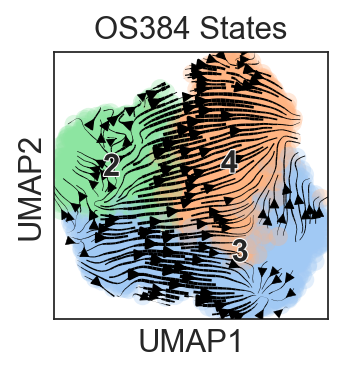

In [4]:
# computing the moments
scv.pp.moments(adata, mode = 'distances')
 

# recovering dynamics
scv.tl.recover_dynamics(adata)

# inferring the DYNAMIC velocities
scv.tl.velocity(adata, mode='dynamical')


# computing the velocity graph
scv.tl.velocity_graph(adata)


# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden'].astype('int64').values)

# Define the number of clusters
n_clusters = len(clusters[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_clusters)

# Create a dictionary that maps each cluster ID to a color from the palette
cluster_colors = dict(zip(sorted(clusters[0].unique()), colors))

# Map the cluster IDs to their corresponding colors
adata.uns['ClusterName_colors'] = [cluster_colors[c] for c in clusters[0]]

# Set the plot style to 'white' to remove grid lines
sns.set_style('white')


# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, basis='umap', color='leiden', 
                                 palette=colors, 
                                 title = 'OS384 States',
                                frameon = True)


saving figure to file ./figures/scvelo_OS384_velocity_embedding_stream.svg


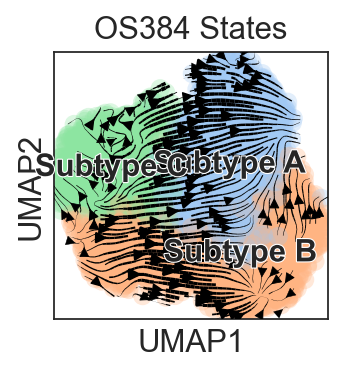

In [5]:
# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, basis='umap', 
                                 color='Subtype', 
                                 palette=colors, 
                                 rasterized=True,
                                 title = 'OS384 States',
                                 frameon = True,
                                 save='OS384_velocity_embedding_stream.svg')

# GSEA

computing score 'IL2_genes_score'
    finished: added
    'IL2_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'MTOR_genes_score'
    finished: added
    'MTOR_genes_score', score of gene set (adata.obs).
    194 total control genes are used. (0:00:00)
computing score 'FOCAL_ADHESION_PI3KAKTMTOR_genes_score'
    finished: added
    'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    195 total control genes are used. (0:00:00)
computing score 'PDGF_ERK1_DOWN_genes_score'
    finished: added
    'PDGF_ERK1_DOWN_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'TNFA_genes_score'
    finished: added
    'TNFA_genes_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'GCNP_genes_score'


    finished: added
    'GCNP_genes_score', score of gene set (adata.obs).
    193 total control genes are used. (0:00:00)
computing score 'CSR_genes_score'
    finished: added
    'CSR_genes_score', score of gene set (adata.obs).
    196 total control genes are used. (0:00:00)
computing score 'ESC_genes_score'
    finished: added
    'ESC_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'PI3KAKTMTOR_genes_score'
    finished: added
    'PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'STK33_genes_score'
    finished: added
    'STK33_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'VEGFA_genes_score'


    finished: added
    'VEGFA_genes_score', score of gene set (adata.obs).
    194 total control genes are used. (0:00:00)
computing score 'KRAS_genes_score'
    finished: added
    'KRAS_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'TGFB_genes_score'
    finished: added
    'TGFB_genes_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'EMT_genes_score'
    finished: added
    'EMT_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'EZH2_genes_score'
    finished: added
    'EZH2_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'LEF1_genes_score'
    finished: added
    'LEF1_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)


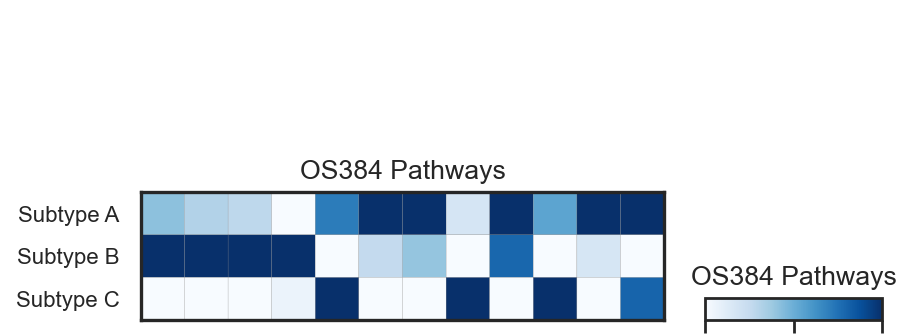

In [5]:
# Define the directory for the gmt files
directory = '/Users/brendamelano/Desktop/gmt_files'


# Create a dictionary to store gene lists
gene_lists = {}


# Create variables for gene lists
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        variable_name = os.path.splitext(filename)[0].upper()
        variable_name += "_genes"
        with open(os.path.join(directory, filename)) as f:
            gene_lists[variable_name] = [line.strip() for line in f]

            
# Create a dictionary to store gene scores for each module
gene_scores = {}

# Quantify enrichment for each gene list
for gene_list_name, gene_list in gene_lists.items():
    scores_key = gene_list_name + "_score"
    try:
        gene_scores[gene_list_name] = sc.tl.score_genes(
            adata, gene_list, ctrl_size=50, gene_pool=None,
            n_bins=5, score_name=scores_key, random_state=0, 
            copy=False, use_raw=None
        )
    except KeyError:
        continue

adata.var_names_make_unique()

# Defining the score names
scores = [ 'MTOR_genes_score', 'GCNP_genes_score', 'CSR_genes_score',   
          'LEF1_genes_score','ESC_genes_score','TNFA_genes_score','PDGF_ERK1_DOWN_genes_score',   
          'KRAS_genes_score', 'TGFB_genes_score','IL2_genes_score',  'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', 
          'STK33_genes_score',]

# Plotting the pathway matrix plot based on subtype
axes_dict = sc.pl.matrixplot(
    adata,
    scores,
    "Subtype",
    dendrogram=False,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    show=False  # This prevents the plot from showing immediately
)


# Remove the x-axis labels
for ax in axes_dict.values():
    ax.set_xticklabels([])  # Remove x-axis labels
    ax.set_title('OS384 Pathways', fontsize=12)

# Save the figure. Ensure that all parts of the figure are on the same figure object
plt.gcf().savefig('/Users/brendamelano/Desktop/OS384_Pathways.svg', format='svg')  # Adjust path as needed

# Show the plot if desired
plt.show()

# Cell type labeling for scVI

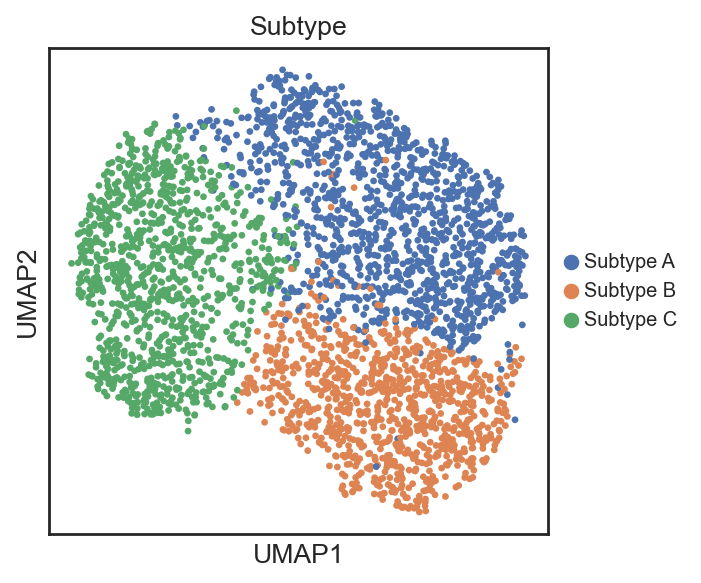

In [5]:
# Converting the cluster to category type
adata.obs['leiden_scVI'] = adata.obs['leiden_scVI'].astype('category')


# 
adata.obs['leiden_scVI'][adata.obs['leiden_scVI']=='1']='3'


# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'Subtype A': ['3'], 'Subtype B': ['2'], 'Subtype C': ['0']}


# Initialize empty column in cell metadata
adata.obs['subtype'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden_scVI).isin(cell_dict[i])
    adata.obs.loc[ind,'Subtype'] = i
    
    
# Plotting the subtype labeled umap
sc.pl.umap(adata, color=['Subtype'], legend_fontsize=9)


# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_scvI_subtype.h5ad")
